# Text Spam Classification

In [23]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

## Initialize the dataframe, etc...

In [24]:
df = pd.read_csv('spam.csv', encoding='latin1')

In [25]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [26]:

df1 = df[['v1', 'v2']]

In [27]:
df1

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [28]:
df1 = df1.rename({'v1': 'SPAM_CLASS', 'v2': 'original_message'}, axis=1)
df1

,SPAM_CLASS,original_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Some feature engineering...

In [29]:
# Capturing some features of the message that might be predictive
# Should later add word count also, maybe special characters.. what else?  probably a lot more we can do here
def count_caps_in_message(message):
    return sum(1 for c in message if c.isupper())
    
def count_punc_in_message(message):
    return sum(1 for c in message if c in string.punctuation)

df1['message_length'] = df1['original_message'].apply(len)   #the length of the message
df1['caps_ratio'] = df1['original_message'].apply(count_caps_in_message) /  df1['message_length']  #ratio of caps to all other chars
df1['punc_ratio'] = df1['original_message'].apply(count_punc_in_message) / df1['message_length']  #ratio of punc to all other chars
df1

,SPAM_CLASS,original_message,message_length,caps_ratio,punc_ratio
0,ham,"Go until jurong point, crazy.. Available only ...",111,0.027027,0.081081
1,ham,Ok lar... Joking wif u oni...,29,0.068966,0.206897
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,0.064516,0.038710
3,ham,U dun say so early hor... U c already then say...,49,0.040816,0.122449
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0.032787,0.032787
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,0.055901,0.049689
5568,ham,Will Ì_ b going to esplanade fr home?,37,0.054054,0.054054
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0.035088,0.122807
5570,ham,The guy did some bitching but I acted like i'd...,125,0.016000,0.008000


In [30]:
#Make the message all lower case for word count dictionary
df1['message_lower'] = df1['original_message'].str.lower()
df1

,SPAM_CLASS,original_message,message_length,caps_ratio,punc_ratio,message_lower
0,ham,"Go until jurong point, crazy.. Available only ...",111,0.027027,0.081081,"go until jurong point, crazy.. available only ..."
1,ham,Ok lar... Joking wif u oni...,29,0.068966,0.206897,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,0.064516,0.038710,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,49,0.040816,0.122449,u dun say so early hor... u c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0.032787,0.032787,"nah i don't think he goes to usf, he lives aro..."
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,0.055901,0.049689,this is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?,37,0.054054,0.054054,will ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s...",57,0.035088,0.122807,"pity, * was in mood for that. so...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...,125,0.016000,0.008000,the guy did some bitching but i acted like i'd...


In [31]:
# Create a dictionary of top 1000 word counts
word_list = []
for index, row in df1.iterrows():
    # scrubbing all punctuation from the word list
    translator = str.maketrans('', '', string.punctuation)
    s_no_punct = str(row['message_lower']).translate(translator)
    words = s_no_punct.split()
    for word in words:
        word_list.append(word)


words = pd.DataFrame(word_list, columns=['word'])
word_counts = words['word'].value_counts().head(1000)
word_count_dict = word_counts.reset_index()
word_count_dict.columns = ['word', 'count']
word_count_dict

,word,count
0,to,2240
1,i,2230
2,you,2124
3,a,1428
4,the,1322
...,...,...
995,doin,10
996,warm,10
997,store,10
998,callertune,10


In [32]:
# Add a column to the df for each word in the word count dict
for index, row in word_count_dict.iterrows():
    df1[row['word']] = 0

# this will count all words in a message that are not in the top 1000
df1['all_other'] = 0

In [33]:
# Add word count to word columns for each message
for index, row in df1.iterrows():
    words = str(row['message_lower']).split()
    for word in words:
        if word in df1.columns:
            df1.at[index, word] += 1
        else:
            df1.at[index, 'all_other'] += 1


In [34]:
df1.head()

,SPAM_CLASS,original_message,message_length,caps_ratio,punc_ratio,message_lower,to,i,you,a,...,film,met,info,representative,doin,warm,store,callertune,leaves,all_other
0,ham,"Go until jurong point, crazy.. Available only ...",111,0.027027,0.081081,"go until jurong point, crazy.. available only ...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,ham,Ok lar... Joking wif u oni...,29,0.068966,0.206897,ok lar... joking wif u oni...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,0.064516,0.038710,free entry in 2 a wkly comp to win fa cup fina...,3,0,0,1,...,0,0,0,0,0,0,0,0,0,10
3,ham,U dun say so early hor... U c already then say...,49,0.040816,0.122449,u dun say so early hor... u c already then say...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0.032787,0.032787,"nah i don't think he goes to usf, he lives aro...",1,1,0,0,...,0,0,0,0,0,0,0,0,0,4


In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Columns: 1007 entries, SPAM_CLASS to all_other
dtypes: float64(2), int64(1002), object(3)
memory usage: 42.8+ MB


## Create feature sets, target sets, model...

In [36]:
X = df1.drop(columns=['SPAM_CLASS', 'original_message', 'message_lower'], axis=1)
X.head()

,message_length,caps_ratio,punc_ratio,to,i,you,a,the,u,and,...,film,met,info,representative,doin,warm,store,callertune,leaves,all_other
0,111,0.027027,0.081081,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,29,0.068966,0.206897,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
2,155,0.064516,0.038710,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,49,0.040816,0.122449,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,2
4,61,0.032787,0.032787,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [37]:
y = df1['SPAM_CLASS']
y = pd.get_dummies(y, drop_first=True)
y.head()

,spam
0,0
1,0
2,1
3,0
4,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
# There the response classes are not evenly distributed...
y_train.value_counts()

spam
0       3860
1        597
dtype: int64

In [40]:
# Resampling with SMOTE to even the response class
smote = SMOTE()
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, y_train)
Y_train_resampled.value_counts()

spam
1       3860
0       3860
dtype: int64

In [41]:
# Trying logistic regresssion for a baseline model
log_model = LogisticRegression(fit_intercept=False, solver='liblinear', random_state=42)
log_model.fit(X_train_resampled, Y_train_resampled.values.ravel())

LogisticRegression(fit_intercept=False, random_state=42, solver='liblinear')

## Baseline Model Results:

In [42]:
y_pred_train = log_model.predict(X_train)
y_pred_test = log_model.predict(X_test)
print('TRAINING SET CLASSIFICATION REPORT')
print(classification_report(y_train, y_pred_train))
print('-------------------------------------')
print('TEST SET CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred_test))
print('-------------------------------------')

TRAINING SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3860
           1       0.93      0.95      0.94       597

    accuracy                           0.98      4457
   macro avg       0.96      0.97      0.97      4457
weighted avg       0.98      0.98      0.98      4457

-------------------------------------
TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       965
           1       0.84      0.88      0.86       150

    accuracy                           0.96      1115
   macro avg       0.91      0.93      0.92      1115
weighted avg       0.96      0.96      0.96      1115

-------------------------------------


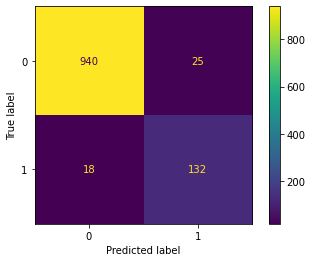

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
cmd = ConfusionMatrixDisplay(conf_matrix)
cmd.plot();

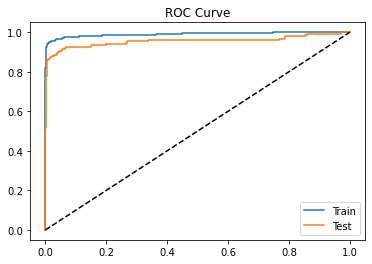

In [44]:
y_test_score = log_model.decision_function(X_test)
y_train_score = log_model.decision_function(X_train)

test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Plot the ROC curves
plt.plot(train_fpr, train_tpr, label='Train')
plt.plot(test_fpr, test_tpr, label='Test')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.title('ROC Curve')
plt.show()

## Not bad results for baseline model... should we pursue this classification problem?  I think there is a lot of room for improving the model:
- should be able to do more feature engineering, EDA etc
- try other models than logistic regresssion
- cross-validation?
- hypertuning, gridseartch?